In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                ])

trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
testset = datasets.MNIST('data', download=True, train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

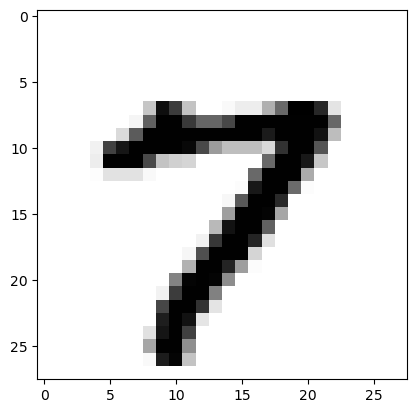

In [3]:
plt.imshow(trainset[5555][0].numpy().squeeze(), cmap='gray_r')

In [4]:
for data, label in trainloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


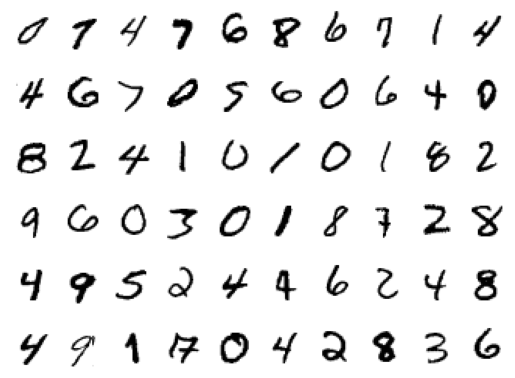

In [5]:

for data, label in trainloader:
    for i, num in enumerate(data):
        if i >= 60:
            break
        plt.subplot(6, 10, i+1)
        plt.axis('off')
        plt.imshow(num.numpy().squeeze(), cmap='gray_r')
    break

In [6]:
class mnist_net(nn.Module):
    def __init__(self):
        super(mnist_net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.log_softmax(self.fc4(x), dim=1)
        return x

In [7]:
print(mnist_net())

mnist_net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [8]:
model = mnist_net()
criterion = nn.NLLLoss()

epochs = 20
learning_rate = 0.005

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
time0 = time()

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.5249732103405286
Epoch 1 - Training loss: 0.15086624277497468
Epoch 2 - Training loss: 0.09909582122175424
Epoch 3 - Training loss: 0.07226955390640541
Epoch 4 - Training loss: 0.053415504967677656
Epoch 5 - Training loss: 0.040542321292800644
Epoch 6 - Training loss: 0.030421849838937066
Epoch 7 - Training loss: 0.024360504726058187
Epoch 8 - Training loss: 0.018694679203841873
Epoch 9 - Training loss: 0.015038454926033853
Epoch 10 - Training loss: 0.010322065546540598
Epoch 11 - Training loss: 0.006907135698929002
Epoch 12 - Training loss: 0.00483805053815863
Epoch 13 - Training loss: 0.002932671004189592
Epoch 14 - Training loss: 0.0017757791649510297
Epoch 15 - Training loss: 0.0011948825902995007
Epoch 16 - Training loss: 0.0008863185931215164
Epoch 17 - Training loss: 0.0007540735390850157
Epoch 18 - Training loss: 0.0006111532137492177
Epoch 19 - Training loss: 0.0005481346267558282

Training Time (in minutes) = 2.3667208512624103


In [9]:
def accuracy(model, testloader):
    correct_count, all_count = 0, 0
    for images, labels in testloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)
            
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if true_label == pred_label:
                correct_count += 1
            all_count += 1
    return correct_count / all_count

print("\nModel Accuracy =", accuracy(model, testloader))



Model Accuracy = 0.9826


In [10]:
torch.save(model, './mnist_net.pth')